In [1]:
# LOAD Packages 
import uproot
import pandas as pd
import numpy as np
import awkward as ak
!pip install awkward_pandas
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import os
import math
import csv
import seaborn as sns
import sympy as smp
import sympy.stats
import json
from scipy import stats,signal,ndimage,special,fft
from scipy.optimize import curve_fit
from scipy.integrate import quad
from mpl_toolkits.axes_grid1 import make_axes_locatable

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Open CAF File 
showers = uproot.open("/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_CC_pi0/caf_studies/plotting/pi0_all_showers_from_CC1pi0_truth_sig_bkg_dict_events.root")
showers["RecoBenchmarkTree"].show()
showers["RecoBenchmarkTree"].keys()
showers["RecoBenchmarkTree"][0].num_entries

# Load CAF File into DataFrame
ak_array = showers["RecoBenchmarkTree"].arrays(library="ak")
caf_df = ak.to_dataframe(ak_array)
caf_df = caf_df.reset_index(drop=True)
num_entries = len(caf_df)
print("Number of Entries: ", num_entries)
caf_df.head()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
reco_energy          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_x             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_y             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_z             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_mag           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_shower_to_vt... | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_x         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_y         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_z         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_shower_start_x  | std::

,reco_energy,reco_p_x,reco_p_y,reco_p_z,reco_p_mag,reco_angle,reco_shower_to_vtx_dist,reco_angle_x,reco_angle_y,reco_angle_z,...,true_ixn_vtx_z_pos,spill_index,file_index,event,run,subrun,caf_file_name,truth_dict_key,ixn_overlap,part_overlap
0,0.050735,-0.041913,0.016053,-0.024731,0.051245,2.094442,1.828186,2.528536,1.252160,2.074427,...,-31.0,14,0,13,0,0,MiniRun6.2_1E19_RHC.caf.0000000.CAF.flat.root,14-61,0.978903,1.000000
1,0.237022,-0.145679,0.159656,0.097299,0.237022,1.191180,4.366984,2.232704,0.831740,1.147788,...,-31.0,14,0,13,0,0,MiniRun6.2_1E19_RHC.caf.0000000.CAF.flat.root,14-61,0.978903,0.968504
2,0.108782,0.025101,-0.056085,-0.089766,0.108782,2.487747,55.224218,1.337951,2.112475,2.541335,...,-31.0,14,0,13,0,0,MiniRun6.2_1E19_RHC.caf.0000000.CAF.flat.root,14-61,0.978903,0.948113
3,0.035297,-0.005653,-0.034884,0.005755,0.035805,1.351816,71.972985,1.729342,2.914329,1.409351,...,-31.0,14,0,13,0,0,MiniRun6.2_1E19_RHC.caf.0000000.CAF.flat.root,14-61,0.978903,0.614035
4,0.007117,0.000000,-0.005383,-0.005383,0.007612,2.297896,101.137002,1.570796,2.356199,2.356190,...,-31.0,14,0,13,0,0,MiniRun6.2_1E19_RHC.caf.0000000.CAF.flat.root,14-61,0.978903,0.123894


In [3]:
# Load Truth/Background Dictionary
sig_bkg_file = open("/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_CC_pi0/caf_studies/plotting/combined_CC1pi0_sig_bkg_dict.json")
sig_bkg_dict = json.load(sig_bkg_file)
sig_bkg_df = pd.DataFrame(sig_bkg_dict)
sig_bkg_df = sig_bkg_df.transpose()
sig_bkg_df["dict_key"] = sig_bkg_df.index
sig_bkg_df.head()

print("Number of Entries in sig_bkg_df: ", len(sig_bkg_df))
signal_only_sig_bkg_df = sig_bkg_df[sig_bkg_df["sig"] == True]
print("Number of Entries in signal_only_sig_bkg_df: ", len(signal_only_sig_bkg_df))
signal_only_decay_diphoton_df = signal_only_sig_bkg_df[signal_only_sig_bkg_df["pi0_child_pdg"].apply(lambda x: np.array(x).shape == (1,2))]
print("Number of Entries in signal_only_decay_diphoton_df: ", len(signal_only_decay_diphoton_df))

Number of Entries in sig_bkg_df:  7937
Number of Entries in signal_only_sig_bkg_df:  1195
Number of Entries in signal_only_decay_diphoton_df:  1181


In [4]:
# Match across dataframes -- add truth info to caf_df
full_df = caf_df
full_df = full_df.join(sig_bkg_df.set_index('dict_key'), on='truth_dict_key', how='outer')
full_df.head()

,reco_energy,reco_p_x,reco_p_y,reco_p_z,reco_p_mag,reco_angle,reco_shower_to_vtx_dist,reco_angle_x,reco_angle_y,reco_angle_z,...,primary_shower_start_pxyz,primary_shower_conv_dist,nu_energy,q2,vtx_x,vtx_y,vtx_z,filepath,flow_event_id,file_number
0.0,0.050735,-0.041913,0.016053,-0.024731,0.051245,2.094442,1.828186,2.528536,1.252160,2.074427,...,[],[],5769.64502,224041.5,-6.306443,33.977135,-31.177608,/global/cfs/cdirs/dune/users/ehinkle/nd_protot...,13,0
1.0,0.237022,-0.145679,0.159656,0.097299,0.237022,1.191180,4.366984,2.232704,0.831740,1.147788,...,[],[],5769.64502,224041.5,-6.306443,33.977135,-31.177608,/global/cfs/cdirs/dune/users/ehinkle/nd_protot...,13,0
2.0,0.108782,0.025101,-0.056085,-0.089766,0.108782,2.487747,55.224218,1.337951,2.112475,2.541335,...,[],[],5769.64502,224041.5,-6.306443,33.977135,-31.177608,/global/cfs/cdirs/dune/users/ehinkle/nd_protot...,13,0
3.0,0.035297,-0.005653,-0.034884,0.005755,0.035805,1.351816,71.972985,1.729342,2.914329,1.409351,...,[],[],5769.64502,224041.5,-6.306443,33.977135,-31.177608,/global/cfs/cdirs/dune/users/ehinkle/nd_protot...,13,0
4.0,0.007117,0.000000,-0.005383,-0.005383,0.007612,2.297896,101.137002,1.570796,2.356199,2.356190,...,[],[],5769.64502,224041.5,-6.306443,33.977135,-31.177608,/global/cfs/cdirs/dune/users/ehinkle/nd_protot...,13,0


In [5]:
# Filter to CC 1pi0 events
cc1pi0_0chpi_df = full_df[full_df["sig"] == True]
num_events = len(np.unique(cc1pi0_0chpi_df["truth_dict_key"]))
num_showers = len(cc1pi0_0chpi_df)
print("Number of Showers: ", num_showers)
print("Number of CC 1pi0 0chpi Events: ", num_events)

# Filter by decay mode (truth)
print("Decay Modes: ", np.unique(cc1pi0_0chpi_df["pi0_child_pdg"]))
cc1pi0_0chpi_df = cc1pi0_0chpi_df[cc1pi0_0chpi_df["pi0_child_pdg"].apply(lambda x: np.array(x).shape == (1,2))]
print("Decay Modes: ", np.unique(cc1pi0_0chpi_df["pi0_child_pdg"]))
num_events = len(np.unique(cc1pi0_0chpi_df["truth_dict_key"]))
print("Number of CC 1pi0 0chpi Events: ", num_events)

Number of Showers:  3176
Number of CC 1pi0 0chpi Events:  1195
Decay Modes:  [list([[-11, 11, 22]]) list([[22, 22]])]
Decay Modes:  [list([[22, 22]])]
Number of CC 1pi0 0chpi Events:  1181


In [6]:
# Set up df to look at containment by event: 
unique_events = np.unique(cc1pi0_0chpi_df["truth_dict_key"])
containment_df = pd.DataFrame()
containment_df["truth_dict_key"] = unique_events

# Set allowances for xyz matching of shower starts
x_allowance = 1.5
y_allowance = 1.5
z_allowance = 1.5

# Loop over events to add info to check containment
for event in unique_events:

    # Initialize flags
    lead_match_found = False
    sublead_match_found = False
    current_lead_max_energy = 0
    current_sublead_max_energy = 0

    # Get all showers in event from full df
    event_df = cc1pi0_0chpi_df[cc1pi0_0chpi_df["truth_dict_key"] == event]
    event_df = event_df.reset_index(drop=True)

    # Initialize reco info
    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_E"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_E"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "num_reco_events"] = len(np.unique(event_df['flow_event_id'])) # number of reco events associated with this truth event
    containment_df.loc[containment_df["truth_dict_key"] == event, "num_extra_lead_reco_showers"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "num_extra_sublead_reco_showers"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "num_extra_unmatched_reco_showers"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_pdg"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_pdg"] = 0

    # Loop over showers in event to add to containment df
    num_reco_showers = len(event_df)

    for i in range(num_reco_showers):
        shower = event_df.iloc[i]

        # Some info only needs to be loaded once per event
        if i == 0:

            # Load true pi0 info 
            containment_df.loc[containment_df["truth_dict_key"] == event, "pi0_true_KE"] = shower["pi0_ke"][0]

            # Load available energy info
            if shower["pi0_child_available_energy"][0][0] > shower["pi0_child_available_energy"][0][1]:
                lead_shower_idx = 0
                sublead_shower_idx = 1
            else:
                lead_shower_idx = 1
                sublead_shower_idx = 0
            containment_df.loc[containment_df["truth_dict_key"] == event, "lead_available_E"] = shower["pi0_child_available_energy"][0][lead_shower_idx]
            containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_available_E"] = shower["pi0_child_available_energy"][0][sublead_shower_idx]

            # Load depo energy info
            containment_df.loc[containment_df["truth_dict_key"] == event, "lead_depo_E"] = shower["pi0_child_edep"][0][lead_shower_idx]
            containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_depo_E"] = shower["pi0_child_edep"][0][sublead_shower_idx]

            # Load primary shower info
            containment_df.loc[containment_df["truth_dict_key"] == event, "num_extra_true_primary_showers"] = len(shower["primary_shower_pdg"])

            # Load pi0 child deposition start information to match with reco showers
            lead_pi0_child_xyz = shower["pi0_child_edep_start"][0][lead_shower_idx]
            sublead_pi0_child_xyz= shower["pi0_child_edep_start"][0][sublead_shower_idx]
            containment_df.loc[containment_df["truth_dict_key"] == event, "lead_edep_start_x"] = lead_pi0_child_xyz[0]
            containment_df.loc[containment_df["truth_dict_key"] == event, "lead_edep_start_y"] = lead_pi0_child_xyz[1]
            containment_df.loc[containment_df["truth_dict_key"] == event, "lead_edep_start_z"] = lead_pi0_child_xyz[2]
            containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_edep_start_x"] = sublead_pi0_child_xyz[0]
            containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_edep_start_y"] = sublead_pi0_child_xyz[1]
            containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_edep_start_z"] = sublead_pi0_child_xyz[2]

        # Load shower info to check with truth info
        shower_start_x = shower["reco_shower_start_x"]
        shower_start_y = shower["reco_shower_start_y"]
        shower_start_z = shower["reco_shower_start_z"]

        # Check if reco shower matches with lead or sublead pi0 child based on start location of shower deposition
        if ((abs(lead_pi0_child_xyz[0] - shower_start_x) <= x_allowance) and \
            (abs(lead_pi0_child_xyz[1] - shower_start_y) <= y_allowance) and \
            (abs(lead_pi0_child_xyz[2] - shower_start_z) <= z_allowance)):

            if lead_match_found == True:
                containment_df.loc[containment_df["truth_dict_key"] == event, "num_extra_lead_reco_showers"] += 1
                if shower["reco_energy"] * 1000 > current_lead_max_energy:
                    current_lead_max_energy = shower["reco_energy"] * 1000 # convert to MeV
                    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_E"] = current_lead_max_energy
                    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_pdg"] = shower["reco_pdg"]
                continue
            if lead_match_found == False:
                lead_match_found = True
                current_lead_max_energy = shower["reco_energy"] * 1000 # convert to MeV
                containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_E"] = current_lead_max_energy
                containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_pdg"] = shower["reco_pdg"]
                continue

        if ((abs(sublead_pi0_child_xyz[0] - shower_start_x) <= x_allowance) and \
            (abs(sublead_pi0_child_xyz[1] - shower_start_y) <= y_allowance) and \
            (abs(sublead_pi0_child_xyz[2] - shower_start_z) <= z_allowance)):

            if sublead_match_found == True:
                containment_df.loc[containment_df["truth_dict_key"] == event, "num_extra_sublead_reco_showers"] += 1
                if shower["reco_energy"] * 1000 > current_sublead_max_energy:
                    current_sublead_max_energy = shower["reco_energy"] * 1000 # convert to MeV
                    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_E"] = current_sublead_max_energy
                    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_pdg"] = shower["reco_pdg"]
                continue
            if sublead_match_found == False:
                sublead_match_found = True
                current_sublead_max_energy = shower["reco_energy"] * 1000 # convert to MeV
                containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_E"] = current_sublead_max_energy
                containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_pdg"] = shower["reco_pdg"]
                continue

        # Add to extra showers if not matched with lead or sublead
        containment_df.loc[containment_df["truth_dict_key"] == event, "num_extra_unmatched_reco_showers"] += 1


In [7]:
# Look at containment df
containment_df.head()


,truth_dict_key,lead_reco_E,sublead_reco_E,num_reco_events,num_extra_lead_reco_showers,num_extra_sublead_reco_showers,num_extra_unmatched_reco_showers,lead_reco_pdg,sublead_reco_pdg,pi0_true_KE,...,sublead_available_E,lead_depo_E,sublead_depo_E,num_extra_true_primary_showers,lead_edep_start_x,lead_edep_start_y,lead_edep_start_z,sublead_edep_start_x,sublead_edep_start_y,sublead_edep_start_z
0,1000072-10003000081,65.297559,55.219062,1.0,0.0,0.0,0.0,22.0,11.0,238.453461,...,161.416336,79.383788,65.806479,0.0,-38.132317,-52.410843,44.258816,-41.205330,-40.125809,39.660591
1,1000136-10006000095,16.266212,54.029271,1.0,0.0,0.0,1.0,22.0,11.0,131.119202,...,73.694702,15.951976,69.729987,0.0,10.072979,-22.634989,-63.274220,11.693514,-7.381377,-37.273582
2,1000143-10007000026,713.407636,0.000000,1.0,1.0,0.0,4.0,22.0,0.0,2397.598145,...,997.062683,653.654194,656.360135,0.0,-26.122526,-18.248356,-48.216908,-32.213814,-15.597027,-33.905743
3,1001151-10017000077,0.000000,35.150997,1.0,0.0,0.0,1.0,0.0,22.0,26.462311,...,49.149368,0.646964,43.069851,0.0,-8.881623,49.322739,11.829842,51.009377,32.544178,8.127398
4,1003115-10035000030,145.088777,199.154034,1.0,0.0,0.0,0.0,22.0,22.0,433.390015,...,269.496002,185.384927,252.773827,1.0,-20.046286,-14.328778,9.891124,-40.131924,-10.504960,0.972529


In [8]:
# Add reco and depo efficiency columns
containment_df["lead_depo_efficiency"] = containment_df["lead_depo_E"] / containment_df["lead_available_E"]
containment_df["sublead_depo_efficiency"] = containment_df["sublead_depo_E"] / containment_df["sublead_available_E"]
containment_df["lead_reco_efficiency"] = containment_df["lead_reco_E"] / containment_df["lead_depo_E"]
containment_df["sublead_reco_efficiency"] = containment_df["sublead_reco_E"] / containment_df["sublead_depo_E"]
containment_df["lead_reco_efficiency"].fillna(0, inplace=True)
containment_df["sublead_reco_efficiency"].fillna(0, inplace=True)

# See if there are any rows with very low lead depo and sublead depo efficiency
low_depo_efficiency = containment_df[(containment_df["lead_depo_efficiency"] < 0.011) & (containment_df["sublead_depo_efficiency"] < 0.011)]
print("Number of rows with very low shower depo efficiency:", len(low_depo_efficiency))


# Energy bins
energy_bins = np.linspace(0, 3000, 31)
print("Energy Bins: ", energy_bins)

# Efficiency bins
eff_bins = np.linspace(0, 1, 11)



Number of rows with very low shower depo efficiency: 75
Energy Bins:  [   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000.]


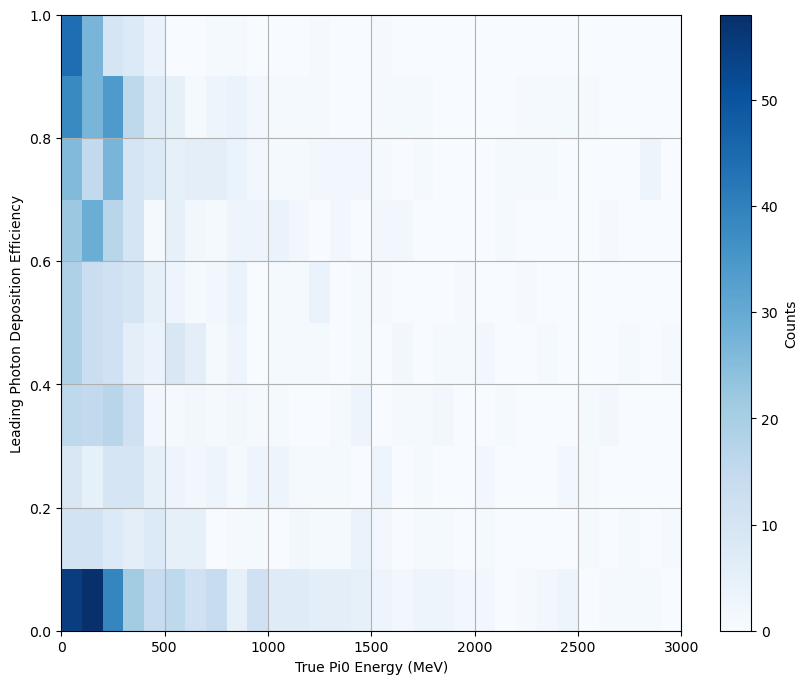

In [9]:
# 2D histogram of pi0 energy vs. lead depo efficiency
plt.figure(figsize=(10, 8))
plt.hist2d(containment_df["pi0_true_KE"], containment_df["lead_depo_efficiency"], bins=[energy_bins, eff_bins], cmap='Blues')
plt.colorbar(label='Counts')
plt.xlabel('True Pi0 Energy (MeV)')
plt.ylabel('Leading Photon Deposition Efficiency')
#plt.title('2D Histogram of Pi0 Energy vs. Lead Depo Efficiency')
plt.grid()
plt.show()

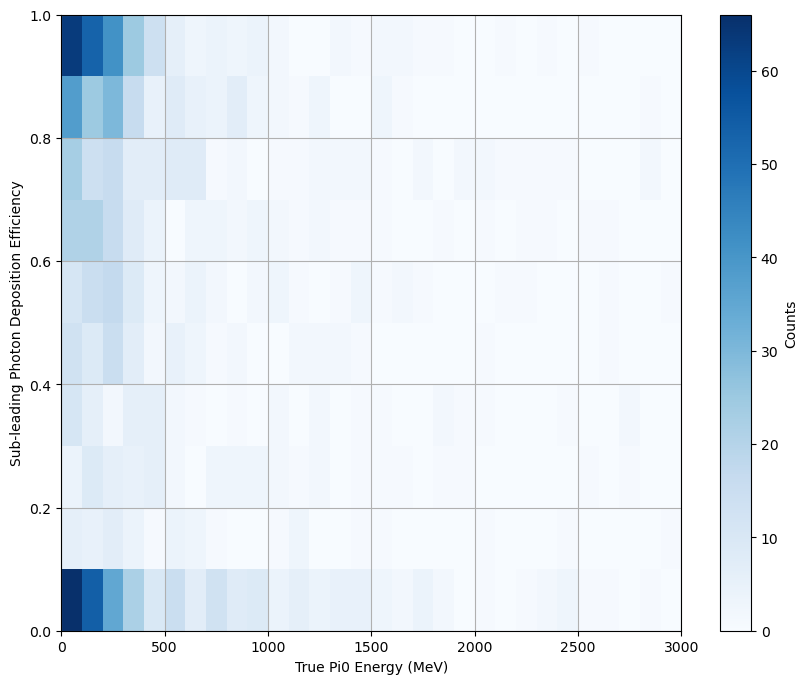

In [10]:
# 2D histogram of pi0 energy vs. sublead depo efficiency
plt.figure(figsize=(10, 8))
plt.hist2d(containment_df["pi0_true_KE"], containment_df["sublead_depo_efficiency"], bins=[energy_bins, eff_bins], cmap='Blues')
plt.colorbar(label='Counts')
plt.xlabel('True Pi0 Energy (MeV)')
plt.ylabel('Sub-leading Photon Deposition Efficiency')
#plt.title('2D Histogram of Pi0 Energy vs. Lead Depo Efficiency')
plt.grid()
plt.show()

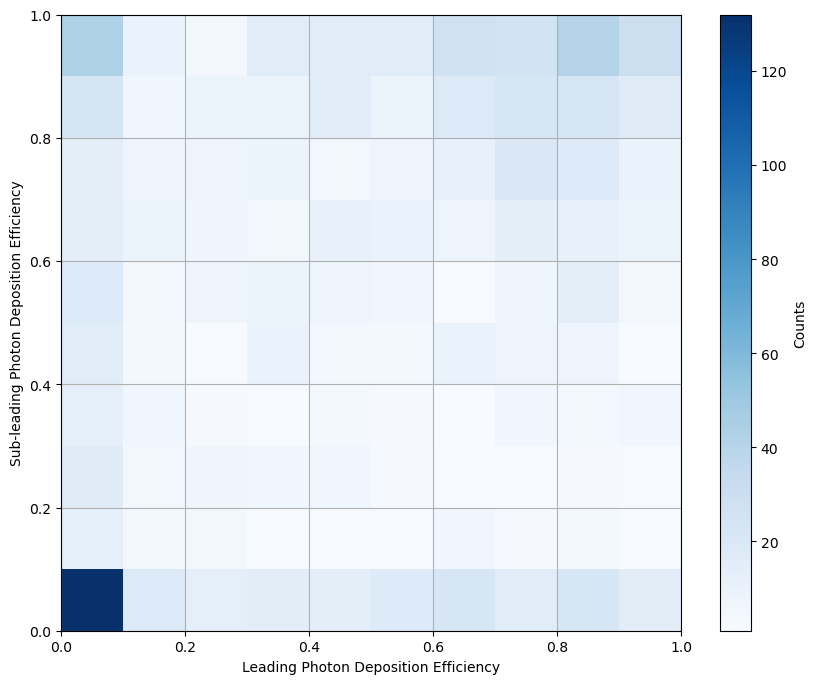

In [11]:
# 2D histogram of lead vs. sublead depo efficiency
plt.figure(figsize=(10, 8))
plt.hist2d(containment_df["lead_depo_efficiency"], containment_df["sublead_depo_efficiency"], bins=[eff_bins, eff_bins], cmap='Blues')
plt.colorbar(label='Counts')
plt.xlabel('Leading Photon Deposition Efficiency')
plt.ylabel('Sub-leading Photon Deposition Efficiency')
#plt.title('2D Histogram of Pi0 Energy vs. Lead Depo Efficiency')
plt.grid()
plt.show()

/tmp/ipykernel_359838/3326929156.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for energy_bin, group in containment_df.groupby('pi0_KE_bin'):


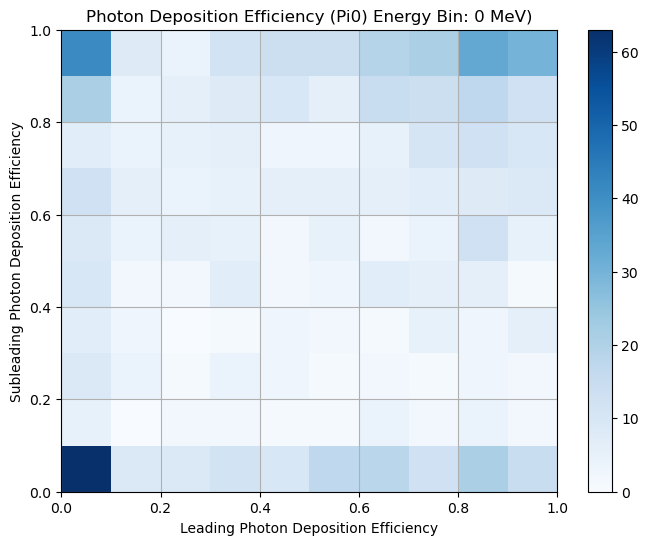

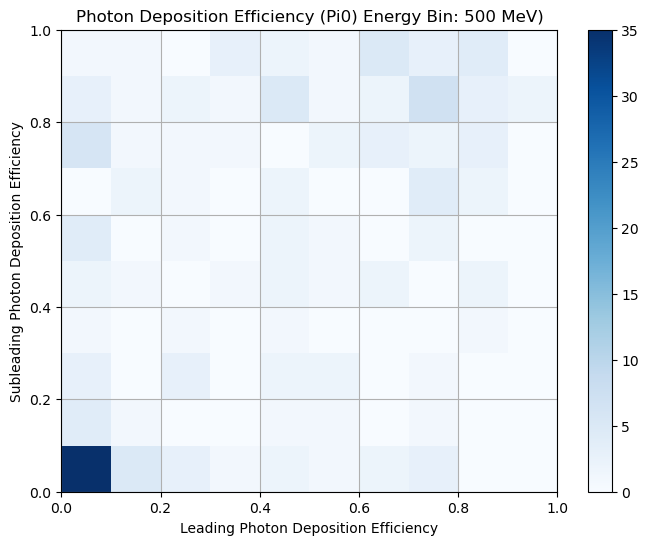

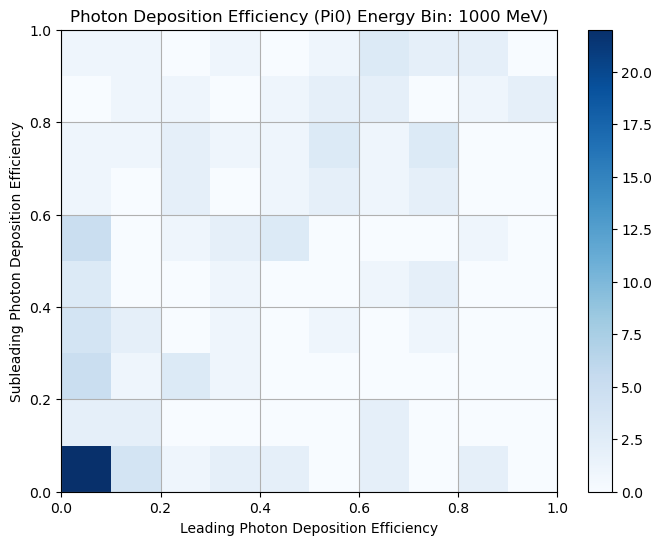

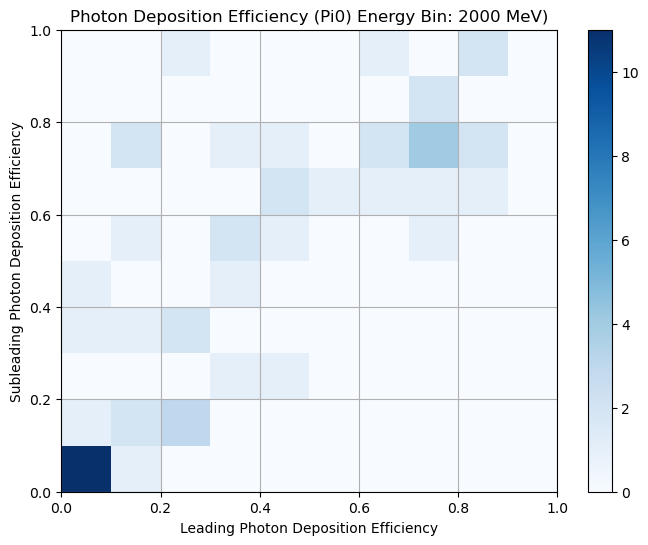

In [12]:

# GitHub Copilot suggestion for group of plots by energy
# Bin the data by energy
energy_bins = [0, 500, 1000, 2000, 5000]
containment_df['pi0_KE_bin'] = pd.cut(
    containment_df['pi0_true_KE'], bins=energy_bins, labels=energy_bins[:-1], include_lowest=True
)

# Iterate over each energy bin and plot
for energy_bin, group in containment_df.groupby('pi0_KE_bin'):
    if group.empty:
        continue  # Skip empty bins

    # Create scatter plot for the current energy bin
    plt.figure(figsize=(8, 6))
    plt.hist2d(
        group['lead_depo_efficiency'], 
        group['sublead_depo_efficiency'], bins=[eff_bins, eff_bins],
        cmap='Blues',
    )
    plt.xlabel('Leading Photon Deposition Efficiency')
    plt.ylabel('Subleading Photon Deposition Efficiency')
    plt.title(f'Photon Deposition Efficiency (Pi0) Energy Bin: {energy_bin} MeV)')
    plt.grid(True)
    plt.colorbar()
    plt.show()

In [13]:
# Filter by depo efficiency (leading and subleading > x %)

depo_energy_cut = 0.8
depo_containment_df = containment_df[containment_df["lead_depo_efficiency"] > depo_energy_cut]
depo_containment_df = depo_containment_df[depo_containment_df["sublead_depo_efficiency"] > depo_energy_cut]

print("Number of Events with Lead and Subleading Depo Efficiency > ", depo_energy_cut, ": ", len(depo_containment_df))

Number of Events with Lead and Subleading Depo Efficiency >  0.8 :  111


In [14]:
depo_energy_almost_okay = 0.7
depo_containment_df_almost_okay = containment_df[containment_df["lead_depo_efficiency"] > depo_energy_almost_okay]
depo_containment_df_almost_okay = depo_containment_df_almost_okay[depo_containment_df_almost_okay["sublead_depo_efficiency"] > depo_energy_almost_okay]
print("Number of Events with Lead and Subleading Depo Efficiency > ", depo_energy_almost_okay, ": ", len(depo_containment_df_almost_okay))

Number of Events with Lead and Subleading Depo Efficiency >  0.7 :  210
